# Numerical Solution of Ramsey/Cass-Koopmans model

[![badge](https://img.shields.io/badge/Launch%20using%20-Econ--ARK-blue)](https://econ-ark.org/materials/ramseycasskoopmans#launch)



## by [Mateo Velásquez-Giraldo](https://github.com/Mv77)

This notebook implements a class representing Ramsey's growth model. Current capacities include:
- Numerically finding the consumption rule using the 'time elimination' method as originally implemented by Alexander Tabarrok and updated by Christopher D. Carroll in this [Wolfram Mathematica notebook](www.econ2.jhu.edu/people/ccarroll/public/LectureNotes/Growth/RamseyNumericSolve.zip)
- Drawing the phase diagram of the model.
- Simulating optimal dynamics from a given starting point.

A formal treatment of the exact version of the model implemented in this notebook can be found in [Christopher Carroll's graduate macroeconomics lecture notes](http://www.econ2.jhu.edu/people/ccarroll/public/LectureNotes/Growth/RamseyCassKoopmans/).


## Time Elimination

The 'time elimination' method is a straightforward way to obtain the slope of the saddle path of the model (the 'consumption function').

The idea is simple.  The model has two dynamic equations:
   * $dc/dt$ is given by the consumption Euler equation
   * $dk/dt$ is given by the dynamic budget constraint

To produce a phase diagram $\{k,c\}$ space, though, we need $dc/dk$.  The 'time elimination' method is simply to note that 

$\left(\frac{dc/dt}{dk/dt}\right)=\left(\frac{dc}{dk}\right)$

If we begin with some point that is on the saddle path (the consumption "policy function"), the equation for $dc/dk$ will tell us how to construct the function at other points along the saddle path

In [1]:
# Setup
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import odeint
from scipy import interpolate

from numpy import linalg as LA

# This is a jupytext paired notebook 
# which can be executed from a terminal command line via "ipython [notebookname].py"
# But a terminal does not permit inline figures, so we need to test jupyter vs terminal
# Google "how can I check if code is executed in the ipython notebook"
def in_ipynb():
    try:
        if str(type(get_ipython())) == "<class 'ipykernel.zmqshell.ZMQInteractiveShell'>":
            return True
        else:
            return False
    except NameError:
        return False

# Determine whether to make the figures inline (for spyder or jupyter)
# vs whatever is the automatic setting that will apply if run from the terminal
if in_ipynb():
    # %matplotlib inline generates a syntax error when run from the shell
    # so do this instead
    get_ipython().run_line_magic('matplotlib', 'inline') 
else:
    get_ipython().run_line_magic('matplotlib', 'auto') 

# Import the plot-figure library matplotlib

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['text.usetex'] = False

In [2]:
# Implement the RCKmod class

class RCKmod:
    """
    A class representing Ramsey/Cass-Koopmans growth models.
    """
    
    def __init__(self,rho,alpha,theta,xi,delta,phi):
        """
        Inputs:
        - rho:   relative risk aversion coefficient for CRRA utility.
        - alpha: capital's share of production in Cobb-Douglas output function.
        - theta: time preference/discount rate.
        - xi:    population growth rate.
        - delta: capital depreciation rate.
        - phi:   labor productivity growth rate.        
        """
        # Assign parameter values
        self.rho = rho
        self.alpha = alpha
        self.theta = theta
        self.xi = xi
        self.delta = delta
        self.phi = phi
        
        # Create empty consumption function
        self.cFunc = None
        
        # Maximum capital
        self.kmax = (1/(self.phi + self.xi + self.delta))**(1/(1-self.alpha))
        
        # Steady state capital
        self.kss = (alpha/(theta + xi + delta + rho*phi))**(1/(1-alpha))
        # Steady state consumption
        self.css = self.kss**alpha - (xi + delta + phi)*self.kss
        
        # Solve the model to create its consumption function
        self.solve()
    
    def output(self,k):
        """
        Cobb-Douglas normalized production function
        """
        return(k**self.alpha)
    
    def dcdt(self,c,k):
        """
        Consumption differential equation
        """
        dc = c/self.rho*(self.alpha*k**(self.alpha - 1) - self.theta -\
                         (self.xi + self.delta) -self.rho*self.phi)
        return(dc)
    
    def dkdt(self,c,k):
        """
        Capital differential equation
        """
        dk = self.output(k) - c - (self.phi + self.xi + self.delta)*k
        return(dk)
        
    def dcdk(self,c,k):
        """
        Differential equation for the time elimination method.
        This corresponds to dc/dk = (dc/dt)/(dk/dt)
        """
        return(self.dcdt(c,k)/self.dkdt(c,k))
    
    def solve(self, eps = 10**(-8), npoints = 400):
        """
        Solves for the model's consumption rule through the time elimination
        method.
        
        Parameters:
        - eps:     disturbance used to prevent dc/dk from becoming 0/0 at
                   the steady state value of capital.
        - npoints: number of points used on each side of the steady
                   state capital for solving the dc/dk equation.
        """
        # K ranges, avoiding kss through a small disturbance
        k_below = np.linspace(self.kss-eps,0.0001,npoints)
        k_above = np.linspace(self.kss+eps,self.kmax,npoints)
        k = np.concatenate((k_below,k_above)).flatten()
        
        # Solve for c on each side of the steady state capital,
        # Using the slope of the saddle path to approximate initial
        # conditions
        c_below = odeint(self.dcdk,
                         self.css - eps*self.slope_ss(), k_below)
        c_above = odeint(self.dcdk,
                         self.css + eps*self.slope_ss(), k_above)
        
        c = np.concatenate((c_below,c_above)).flatten()
        
        # Create consumption function as an interpolation of the
        # numerical solutions.
        self.cFunc = interpolate.interp1d(k,c)
    
    
    def dkdt_opt(self,k,t):
        """
        Differential equation for k assuming optimal c decisions.
        """
        return(self.dkdt(self.cFunc(k),k))
    
    
    def k_dynamics(self,k0,t):
        """
        Simulates optimal capital dynamics from a given starting point.
        Parameters:
        - t : vector of time points at which to solve for capital
        - k0: value of capital at t[0]
        """
        k = odeint(self.dkdt_opt, k0, t)
        return(k)
    
    
    def k0locus(self,k):
        """
        Returns the consumption value that leaves a given ammount of
        effective capital unchanged.
        """
        return(self.output(k) - (self.phi + self.xi + self.delta)*k)
        
    def phase_diagram(self, npoints = 200, arrows = False, n_arrows = 5, labels = True, legend = True):
        """
        Plots the model's phase diagram.
        - npoints:  number of ticks in the k axis.
        - arrows:   boolean to indicate whether or not to draw arrow
                    grid.
        - n_arrows: controls the number of arrows in the grid
        """
        
        k = np.linspace(0.01,self.kmax,npoints)
        
        # Create plot
        plt.figure()
        
        # Plot k0 locus
        plt.plot(k,self.k0locus(k),label = '$\\dot{k}=0$ locus')
        # Plot c0 locus
        plt.axvline(x = self.kss,linestyle = '--',
                    label = '$\\dot{c}=0$ locus')
        # Plot saddle path
        plt.plot(k,self.cFunc(k), label = 'Saddle path')
        # Plot steady state
        plt.plot(self.kss,self.css,'*r', label = 'Steady state')
        
        # Add arrows ilustrating behavior in different parts of
        # the diagram.
        # Taken from:
        # http://systems-sciences.uni-graz.at/etextbook/sw2/phpl_python.html
        if arrows:
            x = np.linspace(k[0],k[-1],n_arrows)
            y = np.linspace(self.cFunc(k[0]),self.cFunc(k[-1]),n_arrows)
            
            X, Y = np.meshgrid(x,y)
            dc = self.dcdt(Y,X)
            dk = self.dkdt(Y,X)
            
            M = (np.hypot(dk, dc))
            M[ M == 0] = 1.
            dk /= M
            dc /= M
            plt.quiver(X, Y, dk, dc, M, pivot='mid', alpha = 0.3)
        
        # Labels
        if labels:
            plt.title('Phase diagram and consumption rule\n(normalized by efficiency units)')
            plt.xlabel('k')
            plt.ylabel('c')
        if legend:
            plt.legend()
        
    
    def J_matrix(self,c,k):
        """
        Returns the matrix of first derivatives of the solution's dynamic system
        evaluated at the point (c,k).
        This matrix is used for linear approximations of the system around point
        (c,k).
        """
        
        J = np.array([[1/self.rho*(self.alpha*k**(self.alpha - 1)-\
                                   self.theta-self.xi-self.delta-self.phi),\
                       c/self.rho*\
                       self.alpha*(self.alpha - 1)*k**(self.alpha - 2)],
                      [-1,
                       self.alpha*k**(self.alpha-1) -\
                       (self.phi + self.xi +self.delta)]])
        
        return(J)
    
    def slope_ss(self):
        """
        Finds the slope of the saddle path at the steady state.
        """
        J = self.J_matrix(self.css,self.kss)
        
        # Find eigenvalues and eigenvectors
        w, v = LA.eig(J)
        # Find position of smallest eigenvalue
        min_eig = np.argsort(w)[0]
        
        # The slope of the saddle path is that
        # generated by the eigenvector of the
        # negative eigenvalue.
        slope = v[0,min_eig]/v[1,min_eig]
        
        return(slope)

## _Example_

This is a quick example of how the class is used.

An instance of the model is first created by assigning the required parameter values.

The model needs to be solved in order to find the consumption rule or 'saddle path'.

In [3]:
# Create and solve model
RCKmodExample = RCKmod(rho = 2,alpha = 0.3,theta = 0.02,xi = 0.01,
                       delta = 0.08,phi = 0.03)
RCKmodExample.solve()

# Test the consumption rule
print('Consumption at k = %1.2f is c = %1.2f'\
      % (RCKmodExample.kss/2, RCKmodExample.cFunc(RCKmodExample.kss/2)))

Consumption at k = 1.13 is c = 0.75


The model's phase diagram can then be generated.

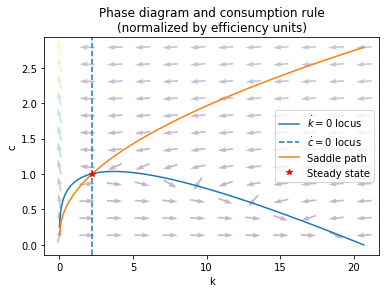

In [4]:
RCKmodExample.phase_diagram(arrows= True, n_arrows = 12)

The $\texttt{RCKmod}$ class can also be used to simulate the dynamics of capital given a starting point.

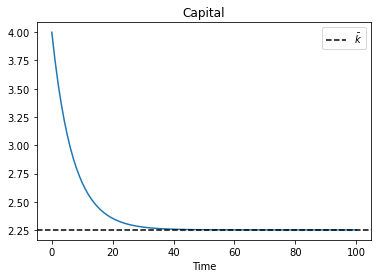

In [5]:
# Create grid of time points
t = np.linspace(0,100,100)

# Find capital dynamics at the desired time points and with
# a given starting capital
k0 = 4
k = RCKmodExample.k_dynamics(k0,t)

# Plot
plt.figure()
plt.plot(t,k)
plt.axhline(y = RCKmodExample.kss,linestyle = '--',color = 'k',
            label = '$\\bar{k}$')
plt.title('Capital')
plt.xlabel('Time')
plt.legend()
plt.show()

With capital, the consumption rule can be used to find the dynamics of consumption.

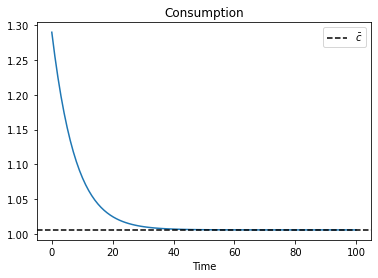

In [6]:
# Find consumption
c = RCKmodExample.cFunc(k)

# Plot
plt.figure()
plt.plot(t,c)
plt.axhline(y = RCKmodExample.css,linestyle = '--',color = 'k',
            label = '$\\bar{c}$')
plt.title('Consumption')
plt.xlabel('Time')
plt.legend()
plt.show()

# Appendix 1: finding the slope of the saddle path at the steady state

From the solution of the model, we know that the system of differential equations that describes the dynamics of $c$ and $k$ is 

\begin{align}
\begin{bmatrix}
\dot{c_t}\\
\dot{k_t}
\end{bmatrix}
=
\begin{bmatrix}
f(c_t,k_t)\\
g(c_t,k_t)
\end{bmatrix}
=
\begin{bmatrix}
\frac{c_t}{\rho}(\alpha k_t^{\alpha - 1} - \theta - \xi - \delta) - \phi\\
k_t^\alpha - c_t - (\phi + \xi + \delta)*k_t
\end{bmatrix}
\end{align}

We seek to approximate this system around the steady state $(\bar{c},\bar{k})$ through

\begin{align}
\begin{bmatrix}
\dot{c_t}\\
\dot{k_t}
\end{bmatrix}
\approx
\begin{bmatrix}
f(\bar{c},\bar{k}) + f_c(\bar{c},\bar{k})(c_t - \bar{c}) + f_k(\bar{c},\bar{k})(k_t - \bar{k})\\
g(\bar{c},\bar{k}) + g_c(\bar{c},\bar{k})(c_t - \bar{c}) + g_k(\bar{c},\bar{k})(k_t - \bar{k})
\end{bmatrix}
\end{align}

For this we find the system's matrix of first derivatives

\begin{align}
J(c,k) =
\begin{bmatrix}
f_c(c,k) & f_k(c,k)\\
g_c(c,k) & g_k(c,k)
\end{bmatrix} = 
\begin{bmatrix}
\frac{1}{\rho}(\alpha k^{\alpha - 1} - \theta - \xi - \delta) - \phi & \frac{c}{\rho}\alpha (\alpha-1) k^{\alpha - 2}\\
-1 & \alpha k^{\alpha - 1} - (\phi + \xi + \delta)
\end{bmatrix}
\end{align}

Given the saddle-path stability of the system, $J(c_{ss},k_{ss})$ will have a positive and a negative eigenvalue. The slope of the saddle path at the steady state capital is given by the eigenvector associated with the negative eigenvalue.

To understand why, rewrite the ODE system as

\begin{align}
\begin{bmatrix}
\dot{c_t}\\
\dot{k_t}
\end{bmatrix}
\approx
\begin{bmatrix}
f(\bar{c},\bar{k})\\
g(\bar{c},\bar{k})
\end{bmatrix}+ J(\bar{c},\bar{k})\times
\begin{bmatrix}
c_t - \bar{c}\\
k_t - \bar{k}
\end{bmatrix}.
\end{align}

Since $(\bar{c},\bar{k})$ are the steady state values, we know $f(\bar{c},\bar{k}) = g(\bar{c},\bar{k}) = 0$. Now define $\hat{c} = c - \bar{c}$ and $\hat{k} = k - \bar{k}$, and notice $\dot{c} = \dot{\hat{c}}$ and $\dot{k} = \dot{\hat{k}}$. With these facts and writting $J(\bar{c},\bar{k}) = J$ to reduce clutter, we have

\begin{align}
\begin{bmatrix}
\dot{\hat{c}_t}\\
\dot{\hat{k}_t}
\end{bmatrix}
\approx
J\times
\begin{bmatrix}
\hat{c}_t\\
\hat{k}_t
\end{bmatrix},
\end{align}

which is a first-order homogeneous ODE system (see ['Matrix differential equation' in Wikipedia](https://en.wikipedia.org/wiki/Matrix_differential_equation)). As discussed in the Wikipedia entry, these systems have solutions of the form

\begin{align}
\begin{bmatrix}
\hat{c}_t\\
\hat{k}_t
\end{bmatrix}
=
c_1 e^{\lambda_1 t}\mathbf{u_1} + c_2 e^{\lambda_2 t}\mathbf{u_2}
\end{align}

where $c_1$ and $c_2$ are constants, $\lambda_1$ and $\lambda_2$ are the eigenvalues of $J$, and $\mathbf{u_1}$ and $\mathbf{u_2}$ are their associated eigenvectors.

For this model, it can be shown that (for all reasonable parameter values) $J$ has a positive and a negative eigenvalue. Thus, assume $\lambda_1 < 0$ and $\lambda_2 > 0$.

We are interested in solutions that approximate to the steady state ($\hat{c}_t = \hat{k}_t =0$) as $t \rightarrow \infty$. For these solutions, we must set $u_2 = 0$: else, given $\lambda_2 > 0$, $e^{\lambda_2 t}\rightarrow \infty$ as $t \rightarrow \infty$ and the system diverges. Therefore, we are left with a solution of the type

\begin{align}
\begin{bmatrix}
\hat{c}_t\\
\hat{k}_t
\end{bmatrix}
=
c_1 e^{\lambda_1 t}\mathbf{u_1} =
\begin{bmatrix}
c_1 e^{\lambda_1 t} u_{1,1}\\
c_1 e^{\lambda_1 t} u_{1,2}
\end{bmatrix}.
\end{align}

Note that, given $\lambda_1<0$, as $t \rightarrow \infty$, $e^{\lambda_1 t}\rightarrow 0$ and $[\hat{c}_t,\hat{k}_t] = [0,0]$ which is precisely what we require.

From the previous solution, we know that in our linear approximation of the dynamic system around $[\hat{c}_t, \hat{k}_t] = [0,0]$, the ratio $\hat{c}_t/\hat{k}_t$ will be the constant $u_{1,1}/u_{1,2}$. Therefore, we can conclude that the slope of the tangent to the saddle path (in k-c coordinates) at the steady state capital $\bar{k}$ will be exactly $u_{1,1}/u_{1,2}$ where $\mathbf{u_1}$ is the eigenvector associated with the negative eigenvalue of the Jacobian matrix J.  This corresponds to the "time elimination" step, because $u_{1,1}$ corresponds to $dc/dt$ and $u_{2,1}$ corresponds to $dk/dt$, so $u_{1,1}/u_{1,2}$ corresponds to $(dc/dt)/(dk/dt)=dc/dk$, which is the slope of the consumption function at the steady state.

# Appendix 2: Figures for Christopher D. Carroll's lecture notes

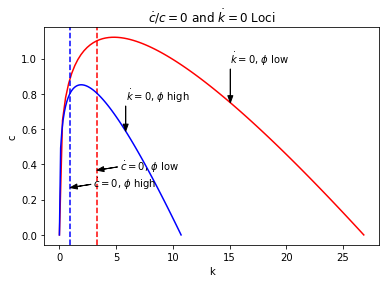

In [7]:
# Figure RamseySSPlot

labels = ['$\phi$ low','$\phi$ high']
colors = ['red','blue']
g = [0.01,0.1]
npoints = 100

plt.figure()
for i in range(len(g)):
    
    # Create model
    RCKmodExample = RCKmod(rho = 2,alpha = 0.3,theta = 0.02,xi = 0.01,
                           delta = 0.08,phi = g[i])
    
    # K range
    k = np.linspace(0,RCKmodExample.kmax,npoints)
        
    # Plot k0 locus
    plt.plot(k,RCKmodExample.k0locus(k),color = colors[i])
    
    k_dummy = (RCKmodExample.kmax + RCKmodExample.kss) / 2
    
    plt.annotate('$\\dot{k}=0$, ' + labels[i],
                 xy=(k_dummy, RCKmodExample.k0locus(k_dummy)),
                 xytext=(k_dummy, RCKmodExample.k0locus(k_dummy)*1.3),
                 arrowprops = dict(color = 'black', width = 0.05,
                                   headwidth = 5, headlength = 7))
    # Plot c0 locus
    plt.axvline(x = RCKmodExample.kss,linestyle = '--',color = colors[i])
    
    plt.annotate('$\\dot{c} = 0$, ' + labels[i],
                 xy=(RCKmodExample.kss, RCKmodExample.css/3),
                 xytext=(RCKmodExample.kss + 2, RCKmodExample.css/3),
                 arrowprops = dict(color = 'black', width = 0.05,
                                   headwidth = 5, headlength = 7))

# Labels
plt.title('$\\dot{c}/c = 0$ and $\\dot{k} = 0$ Loci')
plt.xlabel('k')
plt.ylabel('c')
fig = plt.gcf() # Get the figure in order to save it
fig.savefig('./RamseyCassKoopmans-Figures/RamseySSPlot.svg')
fig.savefig('./RamseyCassKoopmans-Figures/RamseySSPlot.png')
fig.savefig('./RamseyCassKoopmans-Figures/RamseySSPlot.pdf')

plt.show()

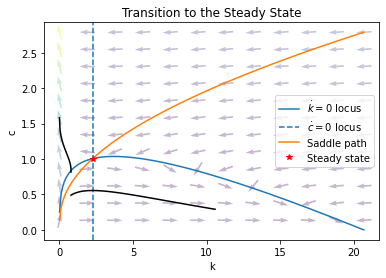

In [8]:
# Figure RamseySaddlePlot
npoints = 100

# Create and solve model
RCKmodExample = RCKmod(rho = 2,alpha = 0.3,theta = 0.02,xi = 0.01,
                       delta = 0.08,phi = 0.03)
RCKmodExample.solve()
pd = RCKmodExample.phase_diagram(arrows= True, n_arrows = 12, labels = False)

# Set initial k for off-path trajectories
k0 = RCKmodExample.kss * 0.35

# Find values of c: one too high, one too low
c_high = RCKmodExample.cFunc(k0) * 1.25
c_low = RCKmodExample.cFunc(k0) * 0.75
init_cs = [c_low, c_high]

# Trajectories with high consumption values become problematic much faster
# than those with low consumption, thus, different time intervals are used
t_final = [20,3.4602]

for i in range(len(init_cs)):
        
    # Create dynamic system for c and k
    dck_dt = lambda ck, t : [RCKmodExample.dcdt(ck[0],ck[1]),
                             RCKmodExample.dkdt(ck[0],ck[1])]
    
    # Create time vector
    t = np.linspace(0,t_final[i],npoints)
    
    # Solve for c and k
    ck = odeint(dck_dt, [init_cs[i], k0], t)
    
    # Plot the trajectory in k-c space
    plt.plot(ck[:,1], ck[:,0], 'k')
    
plt.title('Transition to the Steady State')
plt.xlabel('k')
plt.ylabel('c')
fig = plt.gcf() # Get the figure in order to save it
fig.savefig('./RamseyCassKoopmans-Figures/RamseySaddlePlot.svg')
fig.savefig('./RamseyCassKoopmans-Figures/RamseySaddlePlot.png')
fig.savefig('./RamseyCassKoopmans-Figures/RamseySaddlePlot.pdf')
plt.show()